In [1]:
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import pandas as pd
import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis]
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis]
    return e_x / div

In [3]:
df = pd.read_csv('FB.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,182.500000,186.910004,182.179993,186.899994,186.899994,16628100
1,2018-05-24,185.880005,186.800003,185.029999,185.929993,185.929993,12354700
2,2018-05-25,186.020004,186.330002,184.449997,184.919998,184.919998,10965100
3,2018-05-29,184.339996,186.809998,183.710007,185.740005,185.740005,16398900
4,2018-05-30,186.539993,188.000000,185.250000,187.669998,187.669998,13736900


In [4]:
parameters = [df['Close'].tolist(), df['Volume'].tolist()]

In [5]:
def get_state(parameters, t, window_size = 20):
    outside = []
    d = t - window_size + 1
    for parameter in parameters:
        block = (
            parameter[d : t + 1]
            if d >= 0
            else -d * [parameter[0]] + parameter[0 : t + 1]
        )
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        for i in range(1, window_size, 1):
            res.append(block[i] - block[0])
        outside.append(res)
    return np.array(outside).reshape((1, -1))

Our output size from `get_state` is 38. In this notebook, I only use `Close` and `Volume` parameters, you can choose any parameters you want from your DataFrame.

After that, I want to add another parameters, my `inventory` size, mean of `inventory` and `capital`.

Let say for an example,
```
inventory_size = 1
mean_inventory = 0.5
capital = 2
last_state = 0
```

We have 3 actions,

1. `0` for do nothing.
2. `1` for buy.
3. `2` for sell.

In [6]:
inventory_size = 1
mean_inventory = 0.5
capital = 2
concat_parameters = np.concatenate([get_state(parameters, 20), [[inventory_size, 
                                                                mean_inventory,
                                                                capital]]], axis = 1)

In [7]:
input_size = concat_parameters.shape[1]
input_size

79

In [8]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
    
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')
        
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.rand(input_size, layer_size)
            * np.sqrt(1 / (input_size + layer_size)),
            np.random.rand(layer_size, output_size)
            * np.sqrt(1 / (layer_size + output_size)),
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-2]
        decision = np.dot(feed, self.weights[1]) + self.weights[-1]
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [9]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, timeseries, skip, initial_money, real_trend, minmax):
        self.model = model
        self.timeseries = timeseries
        self.skip = skip
        self.real_trend = real_trend
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )
        self.minmax = minmax
        self._initiate()

    def _initiate(self):
        # i assume first index is the close value
        self.trend = self.timeseries[0]
        self._mean = np.mean(self.trend)
        self._std = np.std(self.trend)
        self._inventory = []
        self._capital = self.initial_money
        self._queue = []
        self._scaled_capital = self.minmax.transform([[self._capital, 2]])[0, 0]

    def reset_capital(self, capital):
        if capital:
            self._capital = capital
        self._scaled_capital = self.minmax.transform([[self._capital, 2]])[0, 0]
        self._queue = []
        self._inventory = []

    def trade(self, data):
        """
        you need to make sure the data is [close, volume]
        """
        scaled_data = self.minmax.transform([data])[0]
        real_close = data[0]
        close = scaled_data[0]
        if len(self._queue) >= window_size:
            self._queue.pop(0)
        self._queue.append(scaled_data)
        if len(self._queue) < window_size:
            return {
                'status': 'data not enough to trade',
                'action': 'fail',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        state = self.get_state(
            window_size - 1,
            self._inventory,
            self._scaled_capital,
            timeseries = np.array(self._queue).T.tolist(),
        )
        action, prob = self.act_softmax(state)
        print(prob)
        if action == 1 and self._scaled_capital >= close:
            self._inventory.append(close)
            self._scaled_capital -= close
            self._capital -= real_close
            return {
                'status': 'buy 1 unit, cost %f' % (real_close),
                'action': 'buy',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }
        elif action == 2 and len(self._inventory):
            bought_price = self._inventory.pop(0)
            self._scaled_capital += close
            self._capital += real_close
            scaled_bought_price = self.minmax.inverse_transform(
                [[bought_price, 2]]
            )[0, 0]
            try:
                invest = (
                    (real_close - scaled_bought_price) / scaled_bought_price
                ) * 100
            except:
                invest = 0
            return {
                'status': 'sell 1 unit, price %f' % (real_close),
                'investment': invest,
                'gain': real_close - scaled_bought_price,
                'balance': self._capital,
                'action': 'sell',
                'timestamp': str(datetime.now()),
            }
        else:
            return {
                'status': 'do nothing',
                'action': 'nothing',
                'balance': self._capital,
                'timestamp': str(datetime.now()),
            }

    def change_data(self, timeseries, skip, initial_money, real_trend, minmax):
        self.timeseries = timeseries
        self.skip = skip
        self.initial_money = initial_money
        self.real_trend = real_trend
        self.minmax = minmax
        self._initiate()

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))

        return np.argmax(decision[0])

    def act_softmax(self, sequence):
        decision = self.model.predict(np.array(sequence))

        return np.argmax(decision[0]), softmax(decision)[0]

    def get_state(self, t, inventory, capital, timeseries):
        state = get_state(timeseries, t)
        len_inventory = len(inventory)
        if len_inventory:
            mean_inventory = np.mean(inventory)
        else:
            mean_inventory = 0
        z_inventory = (mean_inventory - self._mean) / self._std
        z_capital = (capital - self._mean) / self._std
        concat_parameters = np.concatenate(
            [state, [[len_inventory, z_inventory, z_capital]]], axis = 1
        )
        return concat_parameters

    def get_reward(self, weights):
        initial_money = self._scaled_capital
        starting_money = initial_money
        invests = []
        self.model.weights = weights
        inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)

        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= self.trend[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]
                invest = ((self.trend[t] - bought_price) / bought_price) * 100
                invests.append(invest)

            state = self.get_state(
                t + 1, inventory, starting_money, self.timeseries
            )
        invests = np.mean(invests)
        if np.isnan(invests):
            invests = 0
        score = (starting_money - initial_money) / initial_money * 100
        return invests * 0.7 + score * 0.3

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self._scaled_capital
        starting_money = initial_money

        real_initial_money = self.initial_money
        real_starting_money = self.initial_money
        inventory = []
        real_inventory = []
        state = self.get_state(0, inventory, starting_money, self.timeseries)
        states_sell = []
        states_buy = []

        for t in range(0, len(self.trend) - 1, self.skip):
            action, prob = self.act_softmax(state)
            print(t, prob)

            if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - 1 - window_size):
                inventory.append(self.trend[t])
                real_inventory.append(self.real_trend[t])
                real_starting_money -= self.real_trend[t]
                starting_money -= self.trend[t]
                states_buy.append(t)
                print(
                    'day %d: buy 1 unit at price %f, total balance %f'
                    % (t, self.real_trend[t], real_starting_money)
                )

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                real_bought_price = real_inventory.pop(0)
                starting_money += self.trend[t]
                real_starting_money += self.real_trend[t]
                states_sell.append(t)
                try:
                    invest = (
                        (self.real_trend[t] - real_bought_price)
                        / real_bought_price
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.real_trend[t], invest, real_starting_money)
                )
            state = self.get_state(
                t + 1, inventory, starting_money, self.timeseries
            )

        invest = (
            (real_starting_money - real_initial_money) / real_initial_money
        ) * 100
        total_gains = real_starting_money - real_initial_money
        return states_buy, states_sell, total_gains, invest

In [10]:
stocks = [i for i in os.listdir(os.getcwd()) if '.csv' in i and not 'TWTR' in i]
stocks

['CPRT.csv',
 'AMD.csv',
 'GWR.csv',
 'MTDR.csv',
 'GOOG.csv',
 'TSLA.csv',
 'FSV.csv',
 'LB.csv',
 'FB.csv',
 'SINA.csv',
 'LYFT.csv']

I want to train on all stocks I downloaded except for Twitter. I want to use Twitter for testing.

In [11]:
skip = 1
layer_size = 500
output_size = 3
window_size = 20

In [12]:
model = Model(input_size = input_size, layer_size = layer_size, output_size = output_size)
agent = None

for no, stock in enumerate(stocks):
    print('training stock %s'%(stock))
    df = pd.read_csv(stock)
    real_trend = df['Close'].tolist()
    parameters = [df['Close'].tolist(), df['Volume'].tolist()]
    minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
    scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
    initial_money = np.max(parameters[0]) * 2
    
    if no == 0:
        agent = Agent(model = model,
                      timeseries = scaled_parameters,
                      skip = skip,
                      initial_money = initial_money,
                      real_trend = real_trend,
                      minmax = minmax)
    else:
        agent.change_data(timeseries = scaled_parameters,
                          skip = skip,
                          initial_money = initial_money,
                          real_trend = real_trend,
                          minmax = minmax)
    
    agent.fit(iterations = 100, checkpoint = 10)
    print()

training stock CPRT.csv
iter 10. reward: -1.247987
iter 20. reward: 6.464369
iter 30. reward: 20.931005
iter 40. reward: 17.746705
iter 50. reward: 18.576328
iter 60. reward: 21.053296
iter 70. reward: 19.513437
iter 80. reward: 34.468159
iter 90. reward: 18.841612
iter 100. reward: 30.144099
time taken to train: 17.304582357406616 seconds

training stock AMD.csv
iter 10. reward: 36.286963
iter 20. reward: 43.994438
iter 30. reward: 36.426547
iter 40. reward: 40.952264
iter 50. reward: 42.701169
iter 60. reward: 46.964220
iter 70. reward: 50.213138
iter 80. reward: 47.108041
iter 90. reward: 52.502404
iter 100. reward: 55.356372
time taken to train: 18.030934810638428 seconds

training stock GWR.csv
iter 10. reward: 21.827143
iter 20. reward: 26.996406
iter 30. reward: 28.478715
iter 40. reward: 24.769332
iter 50. reward: 32.276361
iter 60. reward: 29.583129
iter 70. reward: 32.912309
iter 80. reward: 33.685202
iter 90. reward: 35.657235
iter 100. reward: 33.971033
time taken to train:

### If you saw the whole training session on certain stocks are negatives (like FB), means that, that stock markets are losing very bad

In [13]:
df = pd.read_csv('GOOG.csv')
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

    
agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

In [14]:
states_buy, states_sell, total_gains, invest = agent.buy()

0 [0. 0. 1.]
1 [0. 0. 1.]
2 [0. 0. 1.]
3 [1. 0. 0.]
4 [0. 0. 1.]
5 [2.88041485e-42 1.00000000e+00 0.00000000e+00]
day 5: buy 1 unit at price 1084.989990, total balance 1490.169922
6 [1. 0. 0.]
7 [0. 0. 1.]
day 7, sell 1 unit at price 1139.290039, investment 5.004659 %, total balance 2629.459961,
8 [0. 0. 1.]
9 [0. 0. 1.]
10 [0. 0. 1.]
11 [0. 0. 1.]
12 [0. 0. 1.]
13 [0. 0. 1.]
14 [0.0000000e+00 1.0000000e+00 1.7139084e-34]
day 14: buy 1 unit at price 1134.790039, total balance 1494.669922
15 [0. 0. 1.]
day 15, sell 1 unit at price 1152.119995, investment 1.527151 %, total balance 2646.789917,
16 [0.00000000e+000 3.38086219e-109 1.00000000e+000]
17 [0. 0. 1.]
18 [0. 1. 0.]
day 18: buy 1 unit at price 1168.060059, total balance 1478.729858
19 [0. 0. 1.]
day 19, sell 1 unit at price 1169.839966, investment 0.152381 %, total balance 2648.569824,
20 [0. 1. 0.]
day 20: buy 1 unit at price 1157.660034, total balance 1490.909790
21 [0. 1. 0.]
day 21: buy 1 unit at price 1155.479980, total balan

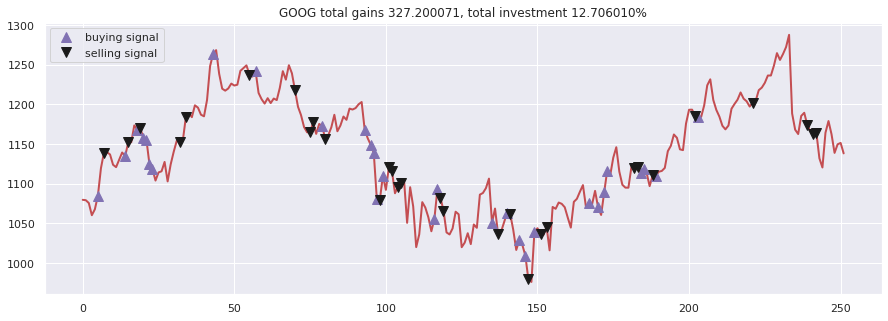

In [15]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('GOOG total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [16]:
df = pd.read_csv('TWTR.csv')
real_trend = df['Close'].tolist()
parameters = [df['Close'].tolist(), df['Volume'].tolist()]
minmax = MinMaxScaler(feature_range = (100, 200)).fit(np.array(parameters).T)
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
initial_money = np.max(parameters[0]) * 2

agent.change_data(timeseries = scaled_parameters,
                  skip = skip,
                  initial_money = initial_money,
                  real_trend = real_trend,
                  minmax = minmax)

states_buy, states_sell, total_gains, invest = agent.buy()

0 [0. 0. 1.]
1 [0. 0. 1.]
2 [0. 0. 1.]
3 [0. 0. 1.]
4 [0. 0. 1.]
5 [0. 0. 1.]
6 [0. 0. 1.]
7 [0. 0. 1.]
8 [0. 0. 1.]
9 [1. 0. 0.]
10 [1. 0. 0.]
11 [0. 1. 0.]
day 11: buy 1 unit at price 41.209999, total balance 52.309997
12 [0. 1. 0.]
day 12: buy 1 unit at price 41.419998, total balance 10.889999
13 [0. 0. 1.]
day 13, sell 1 unit at price 43.490002, investment 5.532645 %, total balance 54.380001,
14 [0. 0. 1.]
day 14, sell 1 unit at price 44.070000, investment 6.397881 %, total balance 98.450001,
15 [0. 1. 0.]
day 15: buy 1 unit at price 46.759998, total balance 51.690003
16 [0. 0. 1.]
day 16, sell 1 unit at price 45.799999, investment -2.053035 %, total balance 97.490002,
17 [0. 0. 1.]
18 [0. 1. 0.]
day 18: buy 1 unit at price 44.950001, total balance 52.540001
19 [0. 1. 0.]
day 19: buy 1 unit at price 46.130001, total balance 6.410000
20 [0. 1. 0.]
21 [0. 1. 0.]
22 [0. 1. 0.]
23 [0. 1. 0.]
24 [0. 1. 0.]
25 [0. 1. 0.]
26 [0. 1. 0.]
27 [1. 0. 0.]
28 [1. 0. 0.]
29 [0. 1. 0.]
30 [0. 1. 0

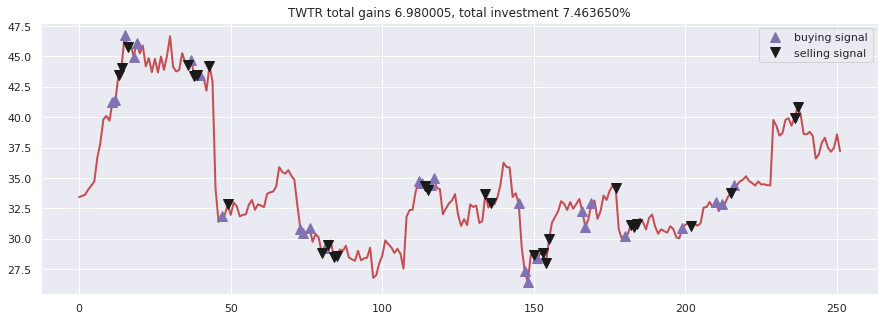

In [17]:
fig = plt.figure(figsize = (15, 5))
plt.plot(df['Close'], color='r', lw=2.)
plt.plot(df['Close'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(df['Close'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('TWTR total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [18]:
from datetime import datetime

volume = df['Volume'].tolist()

for i in range(100):
    print(agent.trade([real_trend[i], volume[i]]))

{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247020'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247175'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247287'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247427'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247529'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247611'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'timestamp': '2019-08-31 02:39:42.247683'}
{'status': 'data not enough to trade', 'action': 'fail', 'balance': 93.51999599999999, 'ti

In [19]:
import copy
import pickle

copy_model = copy.deepcopy(agent.model)

with open('model.pkl', 'wb') as fopen:
    pickle.dump(copy_model, fopen)